# POS tagging using modified Viterbi
- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [1]:
#Importing libraries
import nltk
import re
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd

In [2]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Sindhu\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data[:5]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('For', 'ADP'), ('their', 'PRON'), ('part', 'NOUN'), (',', '.'), ('Taiwan', 'NOUN'), ('and', 'CONJ'), ('South', 'NOUN'), ('Korea', 'NOUN'), ('are', 'VERB'), ('expected', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('step', 'VERB'), ('up', 'PRT'), ('their', 'PRON'), ('own', 'ADJ'), ('investments', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('next', 'ADJ'), ('decade', 'NOUN'), ('*-2', 'X'), ('to', 'PRT'), ('try', 'VERB'), ('*-3', 'X'), ('to', 'PRT'), ('slow', 'VERB'), ('the', 'DET'), ('Japanese', 'ADJ'), ('juggernaut', 'NOUN'), ('.', '.')], [('But', 'CONJ'), ('the', 'DET'), ('most', 'ADV'), ('important', 'ADJ'), ('source', 'NOUN'), ('of', 'ADP'), ('points', 'NOUN'), ('was', 'VERB'), ('student', 'NOUN'), ('improvement', 'NOUN'), ('on', 'ADP'), ('tests', 'NOUN'), ('.', '.')], [('At', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('time', 'NOUN'), (',', '.'), ('you', 'PRON'), ("'ll", 'VERB'), ('give', 'VERB'), ('your', 'PRON'), ('Foster', 'NOUN'), ('Savings', 'NOUN'), ('Institution', 'NOUN'), 

In [5]:
# Getting list of tagged words

train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)
train_tagged_words[:5]

[('For', 'ADP'),
 ('their', 'PRON'),
 ('part', 'NOUN'),
 (',', '.'),
 ('Taiwan', 'NOUN')]

In [6]:
# Extracting tokens

tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['For',
 'their',
 'part',
 ',',
 'Taiwan',
 'and',
 'South',
 'Korea',
 'are',
 'expected']

In [7]:
# vocabulary building
voc = set(tokens)
print(len(voc))

12015


In [8]:
# number of tags
pos_tags = set([pair[1] for pair in train_tagged_words])
print("Number of tags",len(pos_tags))
print("Tags: ",pos_tags)

Number of tags 12
Tags:  {'ADV', '.', 'ADJ', 'CONJ', 'X', 'NOUN', 'DET', 'NUM', 'ADP', 'VERB', 'PRON', 'PRT'}


### Build the vanilla Viterbi based POS tagger

#### Emission Probabilities

In [9]:
# computing P(w/t) and storing in T x V matrix
t = len(pos_tags)
v = len(voc)
word_given_tag = np.zeros((t, v))

In [10]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Transititon Probabilities

In [11]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(pos_tags), len(pos_tags)), dtype='float32')
for i, t1 in enumerate(list(pos_tags)):
    for j, t2 in enumerate(list(pos_tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
        
print("Matrix of tags \n",tags_matrix)

Matrix of tags 
 [[7.91128799e-02 1.35716647e-01 1.27772257e-01 7.28235673e-03
  2.28401199e-02 3.27706076e-02 6.58722296e-02 3.07845082e-02
  1.17179744e-01 3.50877196e-01 1.52267460e-02 1.45647135e-02]
 [5.24095856e-02 9.34218764e-02 4.39737961e-02 5.73454201e-02
  2.69227326e-02 2.22740740e-01 1.74190074e-01 8.02297443e-02
  9.18065161e-02 8.81270766e-02 6.64991438e-02 2.24356097e-03]
 [4.79655992e-03 6.58286437e-02 6.63248450e-02 1.70360561e-02
  2.13364214e-02 6.98312938e-01 4.96195816e-03 2.15018187e-02
  7.67449588e-02 1.22394972e-02 6.61594444e-04 1.02547137e-02]
 [5.35880700e-02 3.40167768e-02 1.17427774e-01 4.65983234e-04
  8.85368139e-03 3.51817340e-01 1.16961792e-01 4.14725058e-02
  5.45200370e-02 1.56570360e-01 5.96458539e-02 4.65983246e-03]
 [2.62778401e-02 1.63916036e-01 1.66639965e-02 1.05752284e-02
  7.43470564e-02 6.26502186e-02 5.43182194e-02 1.92276877e-03
  1.45008817e-01 2.05255568e-01 5.51193729e-02 1.83944881e-01]
 [1.70581136e-02 2.41187856e-01 1.20539134e-02 4

In [13]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(pos_tags), index=list(pos_tags))
tags_df

,ADV,.,ADJ,CONJ,X,NOUN,DET,NUM,ADP,VERB,PRON,PRT
ADV,0.079113,0.135717,0.127772,0.007282,0.022840,0.032771,0.065872,0.030785,0.117180,0.350877,0.015227,0.014565
.,0.052410,0.093422,0.043974,0.057345,0.026923,0.222741,0.174190,0.080230,0.091807,0.088127,0.066499,0.002244
ADJ,0.004797,0.065829,0.066325,0.017036,0.021336,0.698313,0.004962,0.021502,0.076745,0.012239,0.000662,0.010255
CONJ,0.053588,0.034017,0.117428,0.000466,0.008854,0.351817,0.116962,0.041473,0.054520,0.156570,0.059646,0.004660
X,0.026278,0.163916,0.016664,0.010575,0.074347,0.062650,0.054318,0.001923,0.145009,0.205256,0.055119,0.183945
NOUN,0.017058,0.241188,0.012054,0.042627,0.028637,0.264273,0.013113,0.009570,0.176645,0.146656,0.004712,0.043467
DET,0.012827,0.017546,0.204985,0.000484,0.045257,0.637464,0.005687,0.022386,0.009318,0.040537,0.003267,0.000242
NUM,0.002704,0.118690,0.033654,0.013822,0.210637,0.353365,0.003305,0.180589,0.035757,0.018630,0.001502,0.027344
ADP,0.013142,0.039427,0.106849,0.000855,0.035153,0.322898,0.323111,0.062720,0.016989,0.008334,0.069024,0.001496
VERB,0.082524,0.035123,0.064885,0.005362,0.216645,0.110887,0.134742,0.022535,0.091849,0.168545,0.034812,0.032093


### EDA

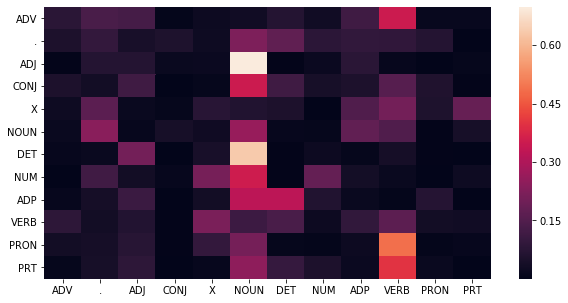

In [14]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(10, 5))
sns.heatmap(tags_df)
plt.show()

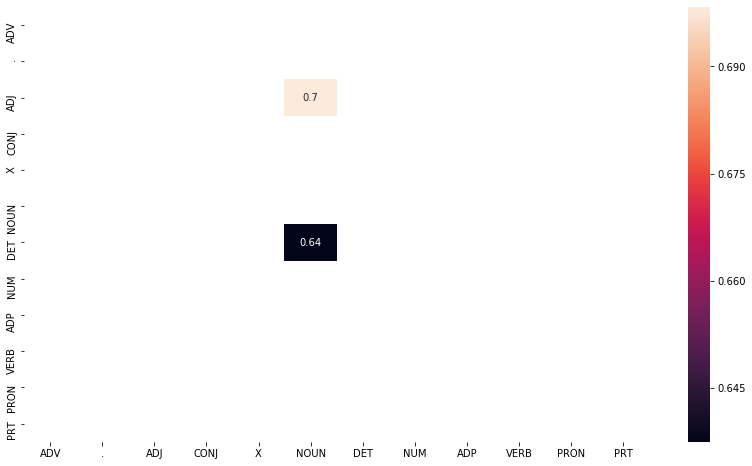

In [15]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5

tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

### Default Viterbi algorithm

In [16]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [17]:
random.seed(1234)

# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]


In [18]:
# tagging the test sentences

tagged_seq = Viterbi(test_tagged_words)

In [25]:
# Viterbi Accuracy

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

accuracy = len(check)/len(tagged_seq)

print("Accuracy :", accuracy)

Accuracy : 0.8991436726926736


Therefore, the accuracy for the original viterbi algorithm is 89.9%

In [21]:
# Extracting incorrect tagged cases
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

530


[[('as', 'ADP'), (('athletic', 'ADV'), ('athletic', 'ADJ'))],
 [('*-2', 'X'), (('to', 'PRT'), ('to', 'ADJ'))],
 [('to', 'ADJ'), (('appeal', 'VERB'), ('appeal', 'NOUN'))],
 [('AT&T', 'NOUN'), (('FAX', 'ADV'), ('FAX', 'NOUN'))],
 [('THE', 'DET'), (('WAR', 'ADV'), ('WAR', 'NOUN'))],
 [('WAR', 'NOUN'), (('OVER', 'ADV'), ('OVER', 'ADP'))],
 [('OVER', 'ADP'), (('FEDERAL', 'NOUN'), ('FEDERAL', 'ADJ'))],
 [('FEDERAL', 'ADJ'), (('JUDICIAL', 'ADV'), ('JUDICIAL', 'ADJ'))],
 [('JUDICIAL', 'ADJ'), (('SALARIES', 'ADV'), ('SALARIES', 'NOUN'))],
 [('the', 'DET'), (('Second', 'ADJ'), ('Second', 'NOUN'))],
 [('of', 'ADP'), (('Appeals', 'ADV'), ('Appeals', 'NOUN'))],
 [('In', 'ADP'), (('mid-October', 'ADV'), ('mid-October', 'NOUN'))],
 [('its', 'PRON'), (('guaranteed', 'ADV'), ('guaranteed', 'VERB'))],
 [('per', 'ADP'), (('subscriber', 'ADV'), ('subscriber', 'NOUN'))],
 [('Time', 'NOUN'), (('costs', 'NOUN'), ('costs', 'VERB'))],
 [('$', '.'), (('120,000', 'ADV'), ('120,000', 'NUM'))],
 [('aggressive', 'A

### Solve the problem of unknown words

In [24]:
# Extracting Unkown Words
test_voc = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - voc)
print("Number of unknown words :", len(unknown_words))
print("Unknown Words :", unknown_words)

Number of unknown words : 393
Unknown Words : ['Restaurant', 'schoolchildren', 'rampage', 'accounted', 'OVER', 'capsules', 'talk-show', '*T*-128', 'ritual', 'Default', 'reservoirs', 'athletic', 'gyrate', 'eighth', 'gelatin', '13\\/16', 'year-long', 'Beta', '221.4', 'shaken', '1.20', 'proviso', 'inviting', 'touched', 'would-be', 'defeated', 'fanfare', 'Fundamentalists', 'Barfield', '609', 'Cote', '87.5', 'south', '3.16', 'Factories', 'direct-mail', '26,956', 'Send', 'Nigel', 'Nomenklatura', 'money-fund', '0.28', 'PLO', 'theaters', 'stark', 'microphone', 'Pakistan', 'rapists', 'bans', 'booked', 'manages', 'exerting', 'Z.', '456.64', 'looked', '93.9', '*T*-226', '38.875', 'wins', 'aggravated', 'H.N.', 'Builders', '3.28', 'implementation', '1.17', 'cost-benefit', 'expunged', '18.3', '89.9', 'Tourism', 'alienated', 'sewer', '*-58', 'tens', 'greenmailer', 'balanced', 'Obligations', 'subscriber', 'policy-making', 'Hurley', 'Allendale', 'buckle', 'pine', 'Mindy', '70.2', 'clannish', 'asserting

#### Method 1 : 
- To take care of the unknown words, we can choose to ignore the words with 0 emission probability and only consider the transition probability. The modification has been implemented below.

In [29]:
# Modified Viterbi Heuristic
def Viterbi_method1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in voc:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [31]:
# Evaluating on test data
unknown_word_tagged_seq = Viterbi_method1(test_tagged_words)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

accuracy_method1 = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("Accuracy after first modification :", accuracy_method1)

Accuracy after first modification : 0.9274976213130353


Accuracy for the first modification is 92.7%, which is better than vanilla viterbi, which was 89.9%

### Method 2
- Using a Trigram Tagger with a bigram tagger as backoff


In [32]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [35]:
def viterbi_method2(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in voc:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [36]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_method2(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

accuracy_method2 = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("Accuracy of of viterbi with trigram tagger :", accuracy_method2)

Accuracy of of viterbi with trigram tagger : 0.9537583254043768


#### Evaluating tagging accuracy

In [41]:
print("Evaluating accuracies of vanilla viterbi algorithm, modification on viterbi using transition prob and modification using trigram tagger ")
print(" Accuracy of vanilla viterbi algorithm",round(accuracy,4)*100,"%")
print(" Accuracy of vanilla viterbi algorithm after first modification ",round(accuracy_method1,4)*100,"%")
print(" Accuracy of vanilla viterbi algorithm after second modification",round(accuracy_method2,4)*100,"%")


Evaluating accuracies of vanilla viterbi algorithm, modification on viterbi using transition prob and modification using trigram tagger 
 Accuracy of vanilla viterbi algorithm 89.91 %
 Accuracy of vanilla viterbi algorithm after first modification  92.75 %
 Accuracy of vanilla viterbi algorithm after second modification 95.38 %


### Checking with sentences provided in Test_sentences.txt

In [43]:
sample_test_sentences = ['Android is a mobile operating system developed by Google.',
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [46]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [48]:
# Extracting untagged words from the sample sentences
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]


# Extracting tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]
sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

### Testing the vanilla viterbi on the sample set

In [56]:
# tagging the test sentences and calculating accuracy
sample_test_tagged_seq = Viterbi(sample_test_tagged_words)
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]
accuracy_default_test = len(sample_test_check)/len(sample_test_tagged_seq)
print("Accuracy of the Vanilla Viterbi Algorithm on the sample test data :", round(accuracy_default_test,4)*100,"%")

Accuracy of the Vanilla Viterbi Algorithm on the sample test data : 75.69 %


### Testing Modification 1 on the sample set

In [57]:
# tagging the test sentences and calculating accuracy
sample_test_unknown_word_tagged_seq = Viterbi_method1(sample_test_tagged_words)
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]
accuracy_method1_test = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)
print("Accuracy of Modification 1 on the sample test data :", round(accuracy_method1_test,4)*100,"%")

Accuracy of Modification 1 on the sample test data : 86.19 %


### Testing Modification 2 on sample set

In [55]:
# tagging the test sentences and calculating accuracy
sample_test_viterbi_trigram_tagged_seq = viterbi_method2(sample_test_tagged_words)
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_test_run_base) if i == j]
accuracy_method2_test = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)
print("Accuracy of Modification 2 on the sample test data:", round(accuracy_method2_test,4)*100,"%")

Accuracy of Modification 2 on the sample test data: 92.82000000000001 %


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [60]:
print("Comparing the accuracies:")
print("Accuracy of vanilla viterbi algorithm :",round(accuracy_default_test,4)*100,"%")
print("Accuracy of Modification 1 :",round(accuracy_method1_test,4)*100,"%")
print("Accuracy of Modification 2 :",round(accuracy_method2_test,4)*100,"%")


Comparing the accuracies:
Accuracy of vanilla viterbi algorithm : 75.69 %
Accuracy of Modification 1 : 86.19 %
Accuracy of Modification 2 : 92.82000000000001 %


#### We can see that the second modification with the trigram tagger provides the highest accuracy of 92.82%

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

### Case 1
#### Using sentence 1 : 'Android is a mobile operating system developed by Google.'

In [68]:
test_sentence_1 = nltk.word_tokenize('Android is a mobile operating system developed by Google.')

# pos tags with default viterbi
pos_tags_vanilla_viterbi = Viterbi(test_sentence_1)
print("Tagging sequence with Default Viterbi algorithm:", pos_tags_vanilla_viterbi)

# pos tags with trigram tagger mod
pos_tags_method2 = viterbi_method2(test_sentence_1)
print("\n Tagging sequence with trigram tagger mod :", pos_tags_method2)

Tagging sequence with Default Viterbi algorithm: [('Android', 'ADV'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADV'), ('.', '.')]

 Tagging sequence with trigram tagger mod : [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


#### - Default Viterbi incorrectly marked 'Android' as ADV and 'Google' as ADV, which is correctly switched to NOUN and NOUN respectively by the trigram tagger modded viterbi.

### Case 2
#### Using sentence 3: "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."

In [71]:
test_sentence_3 = nltk.word_tokenize('Google and Twitter made a deal in 2015 that gave Google access to Twitters firehose.')

# pos tags with default viterbi
pos_tags_vanilla_viterbi_3 = Viterbi(test_sentence_3)
print("Tagging sequence with Default Viterbi algorithm:", pos_tags_vanilla_viterbi_3)

# pos tags with trigram tagger mod
pos_tags_method2_3 = viterbi_method2(test_sentence_3)
print("\n Tagging sequence with trigram tagger mod :", pos_tags_method2_3)

Tagging sequence with Default Viterbi algorithm: [('Google', 'ADV'), ('and', 'CONJ'), ('Twitter', 'ADV'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADV'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADV'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitters', 'ADV'), ('firehose', 'ADV'), ('.', '.')]

 Tagging sequence with trigram tagger mod : [('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitters', 'NOUN'), ('firehose', 'NOUN'), ('.', '.')]


####  Default Viterbi incorrectly marked 'Google' as ADV, '2015' as ADV, ' firehose' as ADV and 'Twitter' as ADV, which have all respectively been corrected to NOUN by the trigram tagger modded viterbi.

### Case 3
#### Using sentence 5 : "Before entering politics, Donald Trump was a domineering businessman and a television personality."

In [73]:
test_sentence_5 = nltk.word_tokenize('Before entering politics, Donald Trump was a domineering businessman and a television personality.')

# pos tags with default viterbi
pos_tags_vanilla_viterbi_5 = Viterbi(test_sentence_5)
print("Tagging sequence with Default Viterbi algorithm:", pos_tags_vanilla_viterbi_5)

# pos tags with trigram tagger mod
pos_tags_method2_5 = viterbi_method2(test_sentence_5)
print("\n Tagging sequence with trigram tagger mod :", pos_tags_method2_5)

Tagging sequence with Default Viterbi algorithm: [('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'ADV'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'ADV'), ('.', '.')]

 Tagging sequence with trigram tagger mod : [('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'VERB'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'NOUN'), ('.', '.')]


#### Default Viterbi incorrectly marked 'domineering' as ADV and 'personality' as ADV, which have both been corrected to VERB and NOUN respectively by the trigram tagger modded viterbi.

### Conclusion
- Modification 2 of viterbi with trigram tagger provies the highest accuracy of 95.38% with tree bank corpora and 92.82% with the sample dataset.